# Eine erste Zeitreihe simulieren

Wir wollen einige Szenarios simulieren, bei denen wir als Eingabe Sensorzeitreihen haben und den Abnutzungsgrad eines Bauteiles oder eine Maschine vorhersagen wollen.

Hierbei sind verschiedene Situationen möglich:
- in nur einer oder in mehreren der Eingabezeitreihen gibt es Signale, die mit dem Abnutzungsgrad zu tun haben
- die Signale treten als Einzelereignis auf bzw. zeigen sich als Trendentwicklung
- der Abnutzungsgrad ist ein kontinuierlicher Wert oder ein diskreter Wert

## Einen Sensorwert simulieren

In [ ]:
import numpy as np

max_time = 3600
dt = 1

t = np.arange(0.0, 3600.0, dt)

In [ ]:
t[:100]

In [ ]:
# Eine Schwingung pro alle 10 Minuten = 600sec
phase = 2*np.pi / 600.0
s = np.sin(t * phase)

In [ ]:
s[:100]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(t, s)
plt.show()

In [ ]:
noise = np.random.normal(0.0, 0.05, size=10000)
plt.hist(noise, bins=50)
plt.show()

In [ ]:
s = np.sin(t * phase) + np.random.normal(0.0, 0.05, size=len(t))

In [ ]:
plt.plot(t, s)
plt.xlim(0,600)
plt.show()

## Schädigendes Ereignis simulieren

In [ ]:
np.random.uniform()

In [ ]:
ereignis_wkeit = 0.01

signal = np.array( [0.5, 0.4, 0.3, 0.2, 0.1] )
N = len(signal)
abnutzungs_werte = []
abnutzung = 0
ereignis = np.zeros(len(t))

s1 = np.sin(t * phase) + np.random.normal(0.0, 0.05, size=len(t))
s2 = np.cos(t * phase) + np.random.normal(0.0, 0.05, size=len(t))
s3 = 1.0 - t/3600 + np.random.normal(0.0, 0.01, size=len(t))

for i in range(len(t)):
    zufallszahl = np.random.uniform()
    if zufallszahl<ereignis_wkeit:
        ereignis[i] = 1
        s1[i:i+N] = s1[i:i+N] + signal
        abnutzung += 0.01                
    abnutzungs_werte.append(  abnutzung )
        
abnutzungs_werte = np.array( abnutzungs_werte )
        
plt.plot(t, s1, "blue", label="s1")
plt.plot(t, s2, "green", label="s2")
plt.plot(t, s3, "orange", label="s3")
plt.plot(t, abnutzungs_werte, "red", label="abnutzung")
plt.plot(t, ereignis, "black", label="ereignis")
#plt.xlim(0,600)
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

print( f"Anz. Abnutzungsereignisse = {np.sum(ereignis)}" )

In [ ]:
type(s1)

In [ ]:
type(abnutzungs_werte)

In [ ]:
len(s1)

In [ ]:
len(abnutzungs_werte)

In [ ]:
s1.shape

In [ ]:
abnutzungs_werte.shape

# Tabelle zur besseren Übersicht

In [ ]:
import pandas

d = {"s1":s1,
     "s2":s2,
     "s3":s3,
     "abnutzung": abnutzungs_werte,
     "ereignis": ereignis}

df = pandas.DataFrame(d)

In [ ]:
df

In [ ]:
print( df.to_string()[:3000] )

# Trainings- und Testdaten vorbereiten

## Ein einzelnes Beispiel extrahieren

In [ ]:
df.values

In [ ]:
df.shape

In [ ]:
start = 20
window_size = 10
time_window = df.values[start:start+window_size]
time_window

In [ ]:
def erzeuge_ein_beispiel(df, start, window_size):
    time_window = df.values[start:start+window_size]
    x = time_window[:,0:3].flatten()
    #y = time_window[:,4]
    y = sum(time_window[:,4])>0
    return x,y

In [ ]:
x,y = erzeuge_ein_beispiel(df, 20, 10)

In [ ]:
x

In [ ]:
y

## Alle Beispiele erzeugen

In [ ]:
window_size = 10
t_bis = 3600-window_size
inp = np.zeros((t_bis,window_size*3))
out = np.zeros((t_bis,1))

In [ ]:
inp.shape

In [ ]:
out.shape

In [ ]:
print( inp[0], "-->", out[0] )

In [ ]:
zeile = 0
for time_step in range(0,t_bis):
    x,y = erzeuge_ein_beispiel(df, time_step, window_size)
    inp[zeile,:] = x
    out[zeile,:] = y
    zeile += 1
    
    if zeile<30:
        print( x, "-->", y )

In [ ]:
print( inp[0], "-->", out[0] )

## Aufspaltung der Beispiele in Trainings- und Testdaten

In [ ]:
inp.shape

In [ ]:
out.shape

In [ ]:
N = int(len(inp)*0.6)
N

In [ ]:
x_train = inp[:N]
y_train = out[:N]
x_test = inp[N:]
y_test = out[N:]

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
x_test.shape

In [ ]:
y_test.shape

# NN erzeugen und trainieren

In [ ]:
nr_inputs = x_test.shape[1]
nr_inputs

In [ ]:
from tensorflow import keras

m = keras.Sequential()
l0 = keras.layers.Input(shape=(nr_inputs,))
l1 = keras.layers.Dense(10, activation="relu")
l2 = keras.layers.Dense(1)
m.add( l0 )
m.add( l1 )
m.add( l2 )
m.summary()

m.compile(optimizer="sgd", loss=keras.losses.MeanSquaredError())

print("Training Start")
history = m.fit(x_train,y_train, epochs=500, verbose=0)
print("Training Ende")

import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.show()

# NN testen auf Testdaten

In [ ]:
x_test.shape

In [ ]:
x_test[0]

In [ ]:
y_test[1]

In [ ]:
preds = m.predict( x_test ).flatten()
preds

In [ ]:
preds.shape

In [ ]:
plt.plot(preds)
plt.show()

In [ ]:
preds_binary = preds>0.5

In [ ]:
preds_binary.shape

In [ ]:
preds_binary[:5]

In [ ]:
sum(preds_binary==0)

In [ ]:
sum(preds_binary==1)

In [ ]:
sum(y_test.flatten()==0)

In [ ]:
sum(y_test.flatten()==1)

In [ ]:
plt.plot(preds_binary)
plt.plot(y_test.flatten()*0.5)
#plt.xlim(0,200)
plt.show()

In [ ]:
y_test.flatten()

In [ ]:
nr_errors = sum(abs(preds_binary - y_test.flatten()))
nr_errors

In [ ]:
percent_errors = (nr_errors / len(x_test))*100.0
percent_errors

# NN testen auf Trainingsdaten

In [ ]:
preds = m.predict( x_train ).flatten()
preds_binary = preds>0.5

In [ ]:
sum(preds_binary==0)

In [ ]:
sum(preds_binary==1)

In [ ]:
sum(y_train.flatten()==0)

In [ ]:
sum(y_train.flatten()==1)

In [ ]:
nr_errors = sum(abs(preds_binary - y_train.flatten()))
nr_errors

In [ ]:
percent_errors = (nr_errors / len(x_test))*100.0
percent_errors

# Alles in einer Codezelle

In [ ]:
# 1. Erzeuge Zeitreihen
########################
import numpy as np
import matplotlib.pyplot as plt
max_time = 3600
dt = 1
t = np.arange(0.0, 3600.0, dt)

ereignis_wkeit = 0.01
signal = np.array( [0.5, 0.4, 0.3, 0.2, 0.1] )
N = len(signal)
abnutzungs_werte = []
abnutzung = 0
ereignis = np.zeros(len(t))

phase = 2*np.pi / 600.0
s1 = np.sin(t * phase) + np.random.normal(0.0, 0.05, size=len(t))
s2 = np.cos(t * phase) + np.random.normal(0.0, 0.05, size=len(t))
s3 = 1.0 - t/3600 + np.random.normal(0.0, 0.01, size=len(t))

for i in range(len(t)):
    zufallszahl = np.random.uniform()
    if zufallszahl<ereignis_wkeit:
        ereignis[i] = 1
        s1[i:i+N] = s1[i:i+N] + signal
        abnutzung += 0.01                
    abnutzungs_werte.append(  abnutzung )
        
abnutzungs_werte = np.array( abnutzungs_werte )
        
plt.plot(t, s1, "blue", label="s1")
plt.plot(t, s2, "green", label="s2")
plt.plot(t, s3, "orange", label="s3")
plt.plot(t, abnutzungs_werte, "red", label="abnutzung")
plt.plot(t, ereignis, "black", label="ereignis")
#plt.xlim(0,600)
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

print( f"Anz. Abnutzungsereignisse = {np.sum(ereignis)}" )


# 2. Erstelle Tabelle zur besseren Übersicht
########################
import pandas
d = {"s1":s1,
     "s2":s2,
     "s3":s3,
     "abnutzung": abnutzungs_werte,
     "ereignis": ereignis}
df = pandas.DataFrame(d)


# 3. Hilfsfunktion um ein Beispiel aus Zeitreihe zu erzeugen
########################
def erzeuge_ein_beispiel(df, start, window_size):
    time_window = df.values[start:start+window_size]
    x = time_window[:,0:3].flatten()
    #y = time_window[:,4]
    y = sum(time_window[:,4])>0
    return x,y


# 4. Alle Beispiele erzeugen
########################
window_size = 10
t_bis = 3600-window_size
inp = np.zeros((t_bis,window_size*3))
out = np.zeros((t_bis,1))

zeile = 0
for time_step in range(0,t_bis):
    x,y = erzeuge_ein_beispiel(df, time_step, window_size)
    inp[zeile,:] = x
    out[zeile,:] = y
    zeile += 1
    
    if zeile<5:
        print( x, "-->", y )
        
        
# 5. Aufspaltung in Trainings- und Testdaten
############################################
N = int(len(inp)*0.6)
x_train = inp[:N]
y_train = out[:N]
x_test = inp[N:]
y_test = out[N:]


# 6. NN erzeugen und trainieren
###############################
from tensorflow import keras

nr_inputs = x_test.shape[1]
m = keras.Sequential()
l0 = keras.layers.Input(shape=(nr_inputs,))
l1 = keras.layers.Dense(10, activation="relu")
l2 = keras.layers.Dense(1)
m.add( l0 )
m.add( l1 )
m.add( l2 )
m.summary()

m.compile(optimizer="sgd", loss=keras.losses.MeanSquaredError())

print("Training Start")
history = m.fit(x_train,y_train, epochs=500, verbose=0)
print("Training Ende")

import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.show()


# 7. NN testen
##############
preds = m.predict( x_test ).flatten()
preds_binary = preds>0.5
plt.plot(preds_binary)
plt.plot(y_test.flatten()*0.5)
plt.show()

nr_errors = sum(abs(preds_binary - y_test.flatten()))
print("Anzahl Fehler: ", nr_errors)
percent_errors = (nr_errors / len(x_test))*100.0
print("Prozent Fehler: ", percent_errors)

# Kontinuierliche Abnutzung vorhersagen

In [ ]:
# 1. Erzeuge Zeitreihen
########################
import numpy as np
import matplotlib.pyplot as plt
max_time = 3600
dt = 1
t = np.arange(0.0, 3600.0, dt)

N = len(signal)
abnutzungs_werte = []
abnutzung = 0

phase = 2*np.pi / 600.0
s1 = t/3600 + np.sin(t * phase) + np.random.normal(0.0, 0.05, size=len(t))
s2 = np.cos(t * phase) + np.random.normal(0.0, 0.05, size=len(t))

for i in range(len(t)):    
    abnutzung += 1/3600
    abnutzungs_werte.append(  abnutzung )
        
abnutzungs_werte = np.array( abnutzungs_werte )
        
plt.plot(t, s1, "blue", label="s1")
plt.plot(t, s2, "green", label="s2")
plt.plot(t, abnutzungs_werte, "red", label="abnutzung")
#plt.xlim(0,600)
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()



# 2. Erstelle Tabelle zur besseren Übersicht
########################
import pandas
d = {"s1":s1,
     "s2":s2,
     "abnutzung": abnutzungs_werte}
df = pandas.DataFrame(d)

print(df)


# 3. Hilfsfunktion um ein Beispiel aus Zeitreihe zu erzeugen
########################
def erzeuge_ein_beispiel(df, start, window_size):
    time_window = df.values[start:start+window_size]
    x = time_window[:,0:2].flatten()
    y = time_window[:,2][-1]
    return x,y


# 4. Alle Beispiele erzeugen
########################
window_size = 120
t_bis = 3600-window_size
inp = np.zeros((t_bis,window_size*2))
out = np.zeros((t_bis,1))

zeile = 0
for time_step in range(0,t_bis):
    x,y = erzeuge_ein_beispiel(df, time_step, window_size)
    if zeile<5:
        print( x, "-->", y )
        
    inp[zeile,:] = x
    out[zeile,:] = y
    zeile += 1   
    
        
        
# 5. Aufspaltung in Trainings- und Testdaten
############################################
N = int(len(inp)*0.6)
x_train = inp[:N]
y_train = out[:N]
x_test = inp[N:]
y_test = out[N:]


# 6. NN erzeugen und trainieren
###############################
from tensorflow import keras

nr_inputs = x_test.shape[1]
m = keras.Sequential()
l0 = keras.layers.Input(shape=(nr_inputs,))
l1 = keras.layers.Dense(100, activation="relu")
l2 = keras.layers.Dense(1)
m.add( l0 )
m.add( l1 )
m.add( l2 )
m.summary()

m.compile(optimizer="adam", loss=keras.losses.MeanSquaredError())

print("Training Start")
history = m.fit(x_train,y_train, epochs=1000, verbose=0)
print("Training Ende")

import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.show()


# 7. NN testen
##############
preds = m.predict( x_test ).flatten()
plt.plot(preds,            "orange", label="Prädiktion der Abnutzung")
plt.plot(y_test.flatten(), "red",    label="Tatsächliche Abnutzung")
plt.legend()
plt.show()

# Prädiktion mit einem RNN

## RNNs brauchen eine andere Input-Shape

In [ ]:
# input has to be a 3D tensor, with shape [batch, nr of timesteps, nr of features]
inputs = np.random.random([8, 5, 2]).astype(np.float32)
inputs

In [ ]:
simple_rnn = keras.layers.SimpleRNN(units=3)

In [ ]:
output = simple_rnn(inputs)

In [ ]:
output

In [ ]:
output.shape

In [ ]:
simple_rnn = keras.layers.SimpleRNN(3, return_sequences=True, return_state=True)
whole_sequence_output, final_state = simple_rnn(inputs)

In [ ]:
final_state

In [ ]:
whole_sequence_output.shape

## RNN Beispiel

Beispiel ist von hier:
https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

Gute Datensatzwebseite:
https://github.com/jbrownlee/Datasets

Doku / Beispiele mit verschiedenen RNN-Zelltypen:
https://www.tensorflow.org/guide/keras/rnn

Epoch 1/20
187/187 - 1s - loss: 0.1377 - 590ms/epoch - 3ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0450 - 297ms/epoch - 2ms/step
Epoch 3/20
187/187 - 0s - loss: 0.0308 - 301ms/epoch - 2ms/step
Epoch 4/20
187/187 - 0s - loss: 0.0235 - 277ms/epoch - 1ms/step
Epoch 5/20
187/187 - 0s - loss: 0.0191 - 265ms/epoch - 1ms/step
Epoch 6/20
187/187 - 0s - loss: 0.0159 - 265ms/epoch - 1ms/step
Epoch 7/20
187/187 - 0s - loss: 0.0135 - 241ms/epoch - 1ms/step
Epoch 8/20
187/187 - 0s - loss: 0.0118 - 188ms/epoch - 1ms/step
Epoch 9/20
187/187 - 0s - loss: 0.0107 - 190ms/epoch - 1ms/step
Epoch 10/20
187/187 - 0s - loss: 0.0098 - 202ms/epoch - 1ms/step
Epoch 11/20
187/187 - 0s - loss: 0.0091 - 192ms/epoch - 1ms/step
Epoch 12/20
187/187 - 0s - loss: 0.0084 - 188ms/epoch - 1ms/step
Epoch 13/20
187/187 - 0s - loss: 0.0077 - 193ms/epoch - 1ms/step
Epoch 14/20
187/187 - 0s - loss: 0.0076 - 194ms/epoch - 1ms/step
Epoch 15/20
187/187 - 0s - loss: 0.0070 - 188ms/epoch - 1ms/step
Epoch 16/20
187/187 - 0s - loss: 0

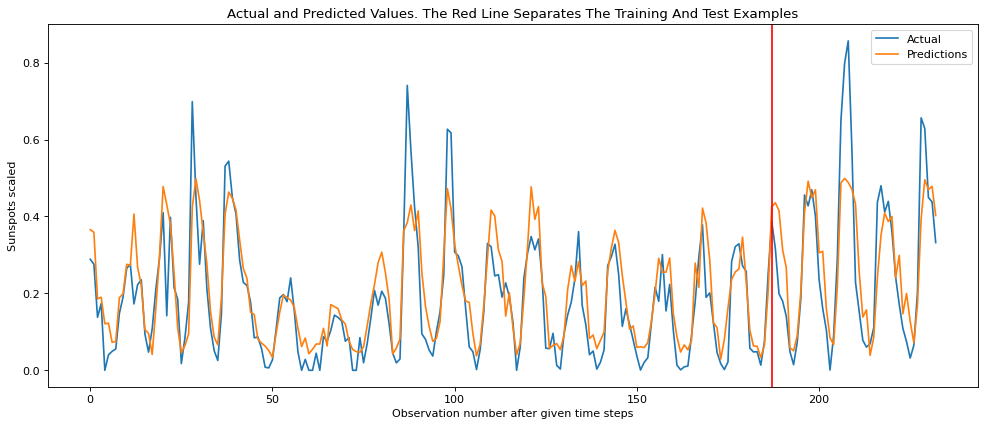

In [19]:
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    #df2 = read_csv(url, engine='python')
    #df2.to_csv("sunspots.csv", index=None)
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    #model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation[0]))
    #model.add(GRU(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps = 12
train_data, test_data, data = get_train_test(sunspots_url)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Create model and train
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

#Plot result
plot_result(trainY, testY, train_predict, test_predict)

In [3]:
train_data.shape

(2256,)

In [4]:
train_data[:10]

array([0.22852638, 0.24665089, 0.2758077 , 0.21946414, 0.33490935,
       0.3289992 , 0.37352246, 0.2612293 , 0.29905435, 0.29747832],
      dtype=float32)

In [5]:
test_data.shape

(564,)

In [7]:
trainX.shape

(187, 12, 1)

In [8]:
trainY.shape

(187,)

In [9]:
testX.shape

(46, 12, 1)

In [10]:
testY.shape

(46,)

In [11]:
print(trainX[0], "-->", trainY[0])

[[0.22852638]
 [0.24665089]
 [0.2758077 ]
 [0.21946414]
 [0.33490935]
 [0.3289992 ]
 [0.37352246]
 [0.2612293 ]
 [0.29905435]
 [0.29747832]
 [0.6249015 ]
 [0.33569738]] --> 0.28881007
